In [38]:
import sys
sys.path.append("../")
import helper
from statsmodels.formula.api import ols

from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime, DataFrame, merge,read_csv,concat
import pandas
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from pmdarima.arima import auto_arima
import seaborn as sb
from sklearn.decomposition import PCA #주성분 분석용 패키지
from pca import pca # 주성분 분석 결과를 DataFrame으로 확인할 수 있는 기능을 제공하는 패키지
from sklearn.linear_model import LinearRegression   #선형회귀분석 모듈
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [2]:
origin=read_excel('인구분석최종ver2.xlsx')
origin.head()

,읍면동명,행정구별_공영주차장_주차면수,행정구별_공영주차장_유무,행정구별_공원수,행정구별_사업체수,행정구별_자동차_등록현황,전체인구,세대당_인구,공공기관수,노인복지시설수,녹지개수,병원수,보건소수,장애인시설,체육시설수,학교수,인구수_대비_도시_구분
0,조치원읍,374,1,16,5141,21246,43324,2.02,9,17,0,75,1,6,70,12,6
1,나성동,572,1,0,0,6687,13507,2.20,0,0,0,57,0,0,29,0,2
2,아름동,236,1,7,1567,11126,23686,2.97,1,0,29,27,0,2,30,8,4
3,고운동,0,0,16,624,17157,35356,2.83,1,0,49,13,0,0,23,16,6
4,종촌동,160,1,2,759,13091,28526,2.63,1,1,12,32,0,4,16,8,5


In [3]:
origin.drop('읍면동명',axis=1,inplace=True)

In [4]:
origin.isna().sum()

행정구별_공영주차장_주차면수    0
행정구별_공영주차장_유무      0
행정구별_공원수           0
행정구별_사업체수          0
행정구별_자동차_등록현황      0
전체인구               0
세대당_인구             0
공공기관수              0
노인복지시설수            0
녹지개수               0
병원수                0
보건소수               0
장애인시설              0
체육시설수              0
학교수                0
인구수_대비_도시_구분       0
dtype: int64

In [5]:
origin.dtypes

행정구별_공영주차장_주차면수      int64
행정구별_공영주차장_유무        int64
행정구별_공원수             int64
행정구별_사업체수            int64
행정구별_자동차_등록현황        int64
전체인구                 int64
세대당_인구             float64
공공기관수                int64
노인복지시설수              int64
녹지개수                 int64
병원수                  int64
보건소수                 int64
장애인시설                int64
체육시설수                int64
학교수                  int64
인구수_대비_도시_구분         int64
dtype: object

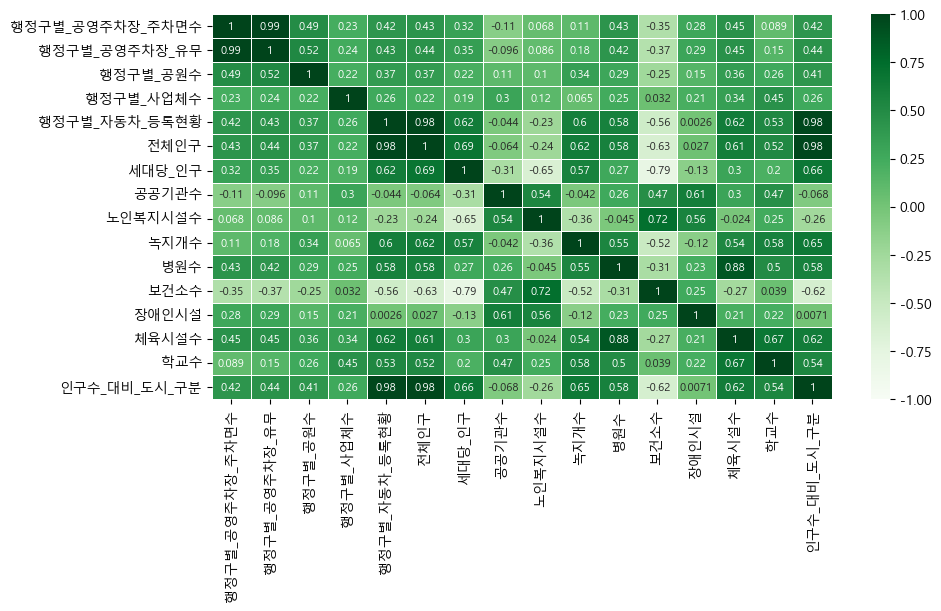

In [6]:
plt.rcParams['font.family'] = 'Malgun Gothic'
#plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams["font.size"] = 10
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams['axes.unicode_minus'] = False

corr = origin.corr(method='spearman')

plt.rcParams["figure.figsize"] = (10,5)

sb.heatmap(corr,
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상(Greys,Purples,Blues,Greens,Oranges,Reds,OrRd,PuRd,RdPu,BuPu,GnBu,PuBu,YlGnBu,PuBuGn,BuGn,YlGn)
           vmin = -1, vmax=1 , #컬러차트 영역 -1 ~ +1
           linewidths=.5, #구분선 굵기
           annot_kws={"size": 8}  # 글자 크기 조정
)

plt.show()
plt.close()

In [19]:
cnames = []
dtypes = origin.dtypes

for i, v in enumerate(dtypes):
    if v != 'category':
        # print(dtypes.index[i], dtypes[i])
        cnames.append(dtypes.index[i])
        
print(cnames)

['행정구별_공영주차장_주차면수', '행정구별_공영주차장_유무', '행정구별_공원수', '행정구별_사업체수', '행정구별_자동차_등록현황', '전체인구', '세대당_인구', '공공기관수', '노인복지시설수', '녹지개수', '병원수', '보건소수', '장애인시설', '체육시설수', '학교수', '인구수_대비_도시_구분']


In [8]:
# 데이터 정규화 진행

x_train_std_df, y_train_std_df = helper.scalling(origin[cnames], '전체인구')
x_train_std_df.head()

,행정구별_공영주차장_주차면수,행정구별_공영주차장_유무,행정구별_공원수,행정구별_사업체수,행정구별_자동차_등록현황,세대당_인구,공공기관수,노인복지시설수,녹지개수,병원수,보건소수,장애인시설,체육시설수,학교수,인구수_대비_도시_구분
0,2.098268,1.732051,2.630218,3.412328,2.536349,-0.539518,4.084862,4.459009,-0.509857,3.251937,0.270501,3.279126,3.882901,1.180032,1.656514
1,3.454677,1.732051,-0.586354,-1.024482,-0.297219,-0.146479,-0.736614,-0.431517,-0.509857,2.247046,-0.811503,-0.559851,1.040063,-1.147702,-0.306762
2,1.152891,1.732051,0.820896,0.327877,0.566728,1.534850,-0.200895,-0.431517,2.006882,0.572229,-0.811503,0.719808,1.109400,0.404120,0.674876
3,-0.463840,-0.577350,2.630218,-0.485955,1.740521,1.229154,-0.200895,-0.431517,3.742564,-0.209352,-0.811503,-0.559851,0.624038,1.955943,1.656514
4,0.632249,1.732051,-0.184283,-0.369446,0.949169,0.792445,-0.200895,-0.143839,0.531553,0.851365,-0.811503,1.999467,0.138675,0.404120,1.165695


In [9]:
# # 표준화 결과를 활용하여 주성분 분석 수행
model = pca()
fit = model.fit_transform(x_train_std_df)
topfeat = fit['topfeat']
topfeat

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [15] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [15] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[8]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


,PC,feature,loading,type
0,PC1,체육시설수,0.360012,best
1,PC2,세대당_인구,-0.431588,best
2,PC3,행정구별_공영주차장_주차면수,0.543446,best
3,PC4,행정구별_사업체수,0.498170,best
4,PC5,행정구별_공원수,0.758498,best
5,PC6,행정구별_공영주차장_유무,-0.540241,best
6,PC7,장애인시설,0.756051,best
7,PC8,행정구별_자동차_등록현황,0.466698,best
8,PC8,공공기관수,-0.307816,weak
9,PC2,노인복지시설수,0.378883,weak


In [10]:
cnames1=cnames.copy()
cnames1.remove('전체인구')
cnames1.remove('공공기관수')
cnames1.remove('인구수_대비_도시_구분')
cnames1.remove('노인복지시설수')
cnames1.remove('녹지개수')
cnames1.remove('병원수')
cnames1.remove('보건소수')
cnames1.remove('학교수')
print(cnames1)

['행정구별_공영주차장_주차면수', '행정구별_공영주차장_유무', '행정구별_공원수', '행정구별_사업체수', '행정구별_자동차_등록현황', '세대당_인구', '장애인시설', '체육시설수']


In [11]:
merge_df = merge(x_train_std_df, y_train_std_df, left_index=True, right_index=True)
df3 = merge_df
df3.head()

,행정구별_공영주차장_주차면수,행정구별_공영주차장_유무,행정구별_공원수,행정구별_사업체수,행정구별_자동차_등록현황,세대당_인구,공공기관수,노인복지시설수,녹지개수,병원수,보건소수,장애인시설,체육시설수,학교수,인구수_대비_도시_구분,전체인구
0,2.098268,1.732051,2.630218,3.412328,2.536349,-0.539518,4.084862,4.459009,-0.509857,3.251937,0.270501,3.279126,3.882901,1.180032,1.656514,2.375853
1,3.454677,1.732051,-0.586354,-1.024482,-0.297219,-0.146479,-0.736614,-0.431517,-0.509857,2.247046,-0.811503,-0.559851,1.040063,-1.147702,-0.306762,-0.246808
2,1.152891,1.732051,0.820896,0.327877,0.566728,1.534850,-0.200895,-0.431517,2.006882,0.572229,-0.811503,0.719808,1.109400,0.404120,0.674876,0.648522
3,-0.463840,-0.577350,2.630218,-0.485955,1.740521,1.229154,-0.200895,-0.431517,3.742564,-0.209352,-0.811503,-0.559851,0.624038,1.955943,1.656514,1.674999
4,0.632249,1.732051,-0.184283,-0.369446,0.949169,0.792445,-0.200895,-0.143839,0.531553,0.851365,-0.811503,1.999467,0.138675,0.404120,1.165695,1.074242


In [12]:
ols_result = helper.myOls(df3, y='전체인구', x = cnames1)
print(ols_result.summary)

                            OLS Regression Results                            
Dep. Variable:                   전체인구   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     285.2
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           5.69e-15
Time:                        14:38:10   Log-Likelihood:                 26.320
No. Observations:                  24   AIC:                            -34.64
Df Residuals:                      15   BIC:                            -24.04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.388e-17      0.021  -6.

In [13]:
ols_result.table

B   표준오차         β        t   유의확률         VIF
종속변수 독립변수                                                                 
전체인구 행정구별_공영주차장_주차면수  -0.0583  0.041 -0.058315  -1.409*  0.179   20.106984
     행정구별_공영주차장_유무     0.0952  0.041  0.095204   2.319*  0.035   16.026517
     행정구별_공원수         -0.0030  0.028 -0.002968  -0.107*  0.916   10.329275
     행정구별_사업체수        -0.0409  0.027 -0.040865  -1.515*  0.150    4.206592
     행정구별_자동차_등록현황     0.9342  0.041  0.934239  22.608*  0.000  240.083368
     세대당_인구            0.0686  0.032  0.068608   2.164*  0.047    6.849611
     장애인시설             0.0097  0.029  0.009748   0.337*  0.740    8.755478
     체육시설수             0.0186  0.045  0.018578   0.412*  0.686   39.865037

In [14]:
ols_result.varstr

['행정구별_공영주차장_주차면수의 회귀계수는 -0.0583(p>0.05)로, 전체인구에 대하여 유의하지 않은 예측변인인 것으로 나타났다.',
 '행정구별_공영주차장_유무의 회귀계수는 0.0952(p<0.05)로, 전체인구에 대하여 유의미한 예측변인인 것으로 나타났다.',
 '행정구별_공원수의 회귀계수는 -0.0030(p>0.05)로, 전체인구에 대하여 유의하지 않은 예측변인인 것으로 나타났다.',
 '행정구별_사업체수의 회귀계수는 -0.0409(p>0.05)로, 전체인구에 대하여 유의하지 않은 예측변인인 것으로 나타났다.',
 '행정구별_자동차_등록현황의 회귀계수는 0.9342(p<0.05)로, 전체인구에 대하여 유의미한 예측변인인 것으로 나타났다.',
 '세대당_인구의 회귀계수는 0.0686(p<0.05)로, 전체인구에 대하여 유의미한 예측변인인 것으로 나타났다.',
 '장애인시설의 회귀계수는 0.0097(p>0.05)로, 전체인구에 대하여 유의하지 않은 예측변인인 것으로 나타났다.',
 '체육시설수의 회귀계수는 0.0186(p>0.05)로, 전체인구에 대하여 유의하지 않은 예측변인인 것으로 나타났다.']

In [24]:
ols_result.result

'𝑅(0.993), 𝑅^2(0.990), 𝐹(285.2), 유의확률(5.69e-15), Durbin-Watson(1.926)'

In [25]:
ols_result.goodness

'전체인구에 대하여 행정구별_공영주차장_주차면수,행정구별_공영주차장_유무,행정구별_공원수,행정구별_사업체수,행정구별_자동차_등록현황,세대당_인구,장애인시설,체육시설수로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(8,15) = 285.2, p < 0.05).'

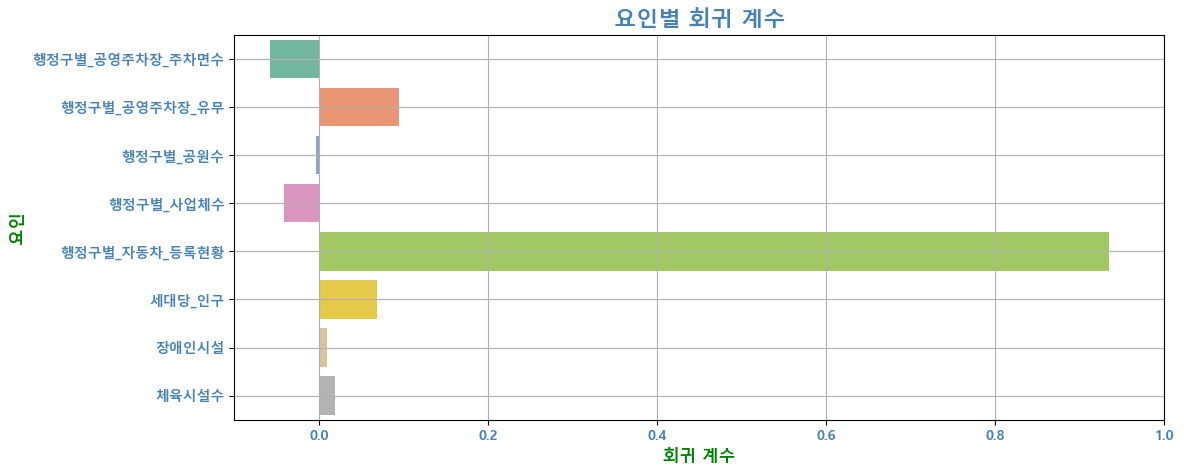

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# 주어진 회귀 계수 정보
coef_values = [
    {'name': '행정구별_공영주차장_주차면수', 'coef': -0.0583},
    {'name': '행정구별_공영주차장_유무', 'coef': 0.0952},
    {'name': '행정구별_공원수', 'coef': -0.0030},
    {'name': '행정구별_사업체수', 'coef': -0.0409},
    {'name': '행정구별_자동차_등록현황', 'coef': 0.9342},
    {'name': '세대당_인구', 'coef': 0.0686},
    {'name': '장애인시설', 'coef': 0.0097},
    {'name': '체육시설수', 'coef': 0.0186}
]

# 데이터 프레임 생성
coef_df = DataFrame(coef_values)

# 막대 그래프 그리기
plt.figure(figsize=(12, 5))
sns.barplot(x='coef', y='name', data=coef_df, orient='h',palette='Set2')
plt.title('요인별 회귀 계수', fontsize=16, color='steelblue',fontweight='bold')
plt.xlabel('회귀 계수', fontsize=12, color='green',fontweight='bold')
plt.ylabel('요인', fontsize=12, color='green',fontweight='bold')
plt.xlim(-0.1, 1.0)
plt.xticks(color='steelblue',fontweight='bold')
plt.yticks(color='steelblue',fontweight='bold')
plt.grid()
plt.show()
plt.close()


In [15]:
origin10=origin.copy()

In [16]:
# 데이터 프레임에서 독립 변수(X)와 종속 변수(y)를 분리합니다.
X = origin10.drop(columns=['전체인구'])  # 종속 변수를 제외한 나머지 열
y = origin10['전체인구']  # 종속 변수

# StandardScaler를 사용하여 데이터를 표준화합니다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 훈련 데이터와 검증 데이터로 분할합니다.
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.3)

# LinearRegression 모델을 생성하고 훈련 데이터로 학습합니다.
model = LinearRegression()
model.fit(X_train, y_train)

# 훈련 데이터에 대한 예측
y_train_pred = model.predict(X_train)

# 검증 데이터에 대한 예측
y_valid_pred = model.predict(X_valid)

# 모델 성능 평가
train_mse = mean_squared_error(y_train, y_train_pred)
valid_mse = mean_squared_error(y_valid, y_valid_pred)
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print("훈련 데이터 MSE:", train_mse)
print("검증 데이터 MSE:", valid_mse)
print("훈련 데이터 R-squared:", train_r2)
print("검증 데이터 R-squared:", valid_r2)


훈련 데이터 MSE: 2.143431762278033e-22
검증 데이터 MSE: 51268338.37127009
훈련 데이터 R-squared: 1.0
검증 데이터 R-squared: 0.7435993624182902


> 훈련 데이터 MSE (Mean Squared Error): 훈련 데이터에서 모델의 평균 제곱 오차는 거의 0에 가깝습니다. 이는 모델이 훈련 데이터를 완벽하게 맞추고 있다는 것을 나타냅니다. 하지만 이것은 모델이 훈련 데이터에 과적합되었을 가능성을 시사합니다. 모델이 훈련 데이터에 너무 적합하게 되면 새로운 데이터에 대한 일반화 능력이 저하될 수 있습니다.

> 검증 데이터 MSE: 검증 데이터에서 모델의 MSE는 상당히 높습니다. 이 값은 모델이 검증 데이터에서 예측 오차가 크다는 것을 나타냅니다. 모델이 훈련 데이터에 과적합되었기 때문에 검증 데이터에서 예측이 부정확한 것으로 보입니다.

> 훈련 데이터 R-squared: 훈련 데이터에서 R-squared (결정 계수) 값은 1.0으로, 모델이 훈련 데이터를 완벽하게 설명하고 있다는 것을 나타냅니다. 다시, 이것은 과적합의 가능성을 시사합니다.

> 검증 데이터 R-squared: 검증 데이터에서 R-squared 값은 0.74로, 모델이 검증 데이터의 분산 중 약 74%를 설명하고 있다는 것을 의미합니다. 이 값은 모델이 일부 정보를 잘 설명하고 있지만, 여전히 개선의 여지가 있는 것을 나타냅니다.

> 종합적으로, 이 모델은 훈련 데이터에서는 매우 높은 성능을 보이지만, 검증 데이터에서는 예측 불안정성이 있고, 과적합의 가능성이 큰 것으로 나타납니다. 모델의 일반화 성능을 향상시키기 위해 모델을 조정하거나 다른 모델을 고려하는 것이 유용할 수 있습니다.







### 각각의 요인별 중요도 확인

In [17]:
# 회귀 계수(coefficients)를 확인합니다.
coefficients = model.coef_
intercept = model.intercept_

# 각 피처의 회귀 계수를 출력합니다.
for feature, coefficient in zip(X.columns, coefficients):
    print(f"{feature}: {coefficient}")

print(f"Intercept: {intercept}")

행정구별_공영주차장_주차면수: 2940.936999744619
행정구별_공영주차장_유무: -1538.7878391648585
행정구별_공원수: -1464.5579510111477
행정구별_사업체수: 837.8468600655342
행정구별_자동차_등록현황: 24245.39169239684
세대당_인구: 1232.1908666212205
공공기관수: -2326.282324391809
노인복지시설수: 678.0762677439945
녹지개수: -471.2926309399049
병원수: -1954.0507844210938
보건소수: -1959.993821151291
장애인시설: 2637.3656246890523
체육시설수: -258.56197372231253
학교수: 2803.799854351316
인구수_대비_도시_구분: -13946.526637470952
Intercept: 15222.717123965587


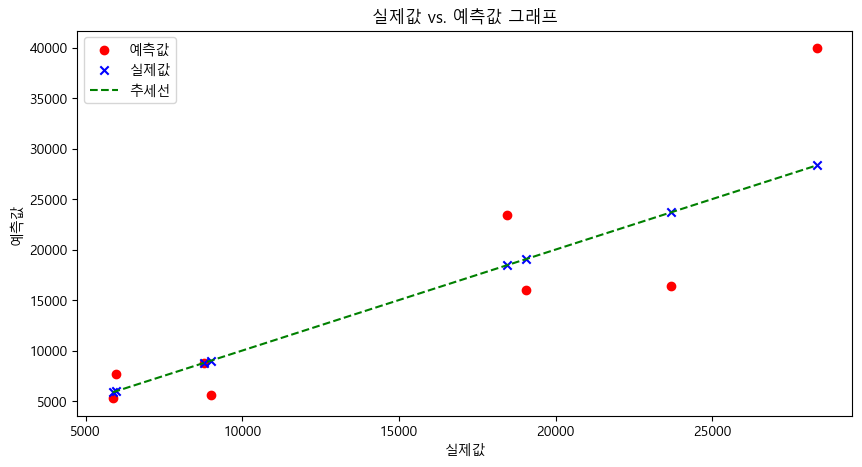

In [40]:
# 실제값 vs. 예측값 그래프 (예측값: 빨간색 점, 실제값: 파란색 점)
plt.scatter(y_valid, y_valid_pred, color='red', marker='o', label='예측값')
plt.scatter(y_valid, y_valid, color='blue', marker='x', label='실제값')

# 추세선을 그리기 위해 x와 y 값의 배열을 생성합니다.
x_range = np.linspace(min(y_valid), max(y_valid), 100)  # x 범위를 실제값의 범위로 설정
y_range = x_range  # 추세선은 y=x 형태

# 추세선 그리기
plt.plot(x_range, y_range, color='green', linestyle='--', label='추세선')

plt.xlabel("실제값")
plt.ylabel("예측값")
plt.title("실제값 vs. 예측값 그래프")
plt.legend()
plt.show()

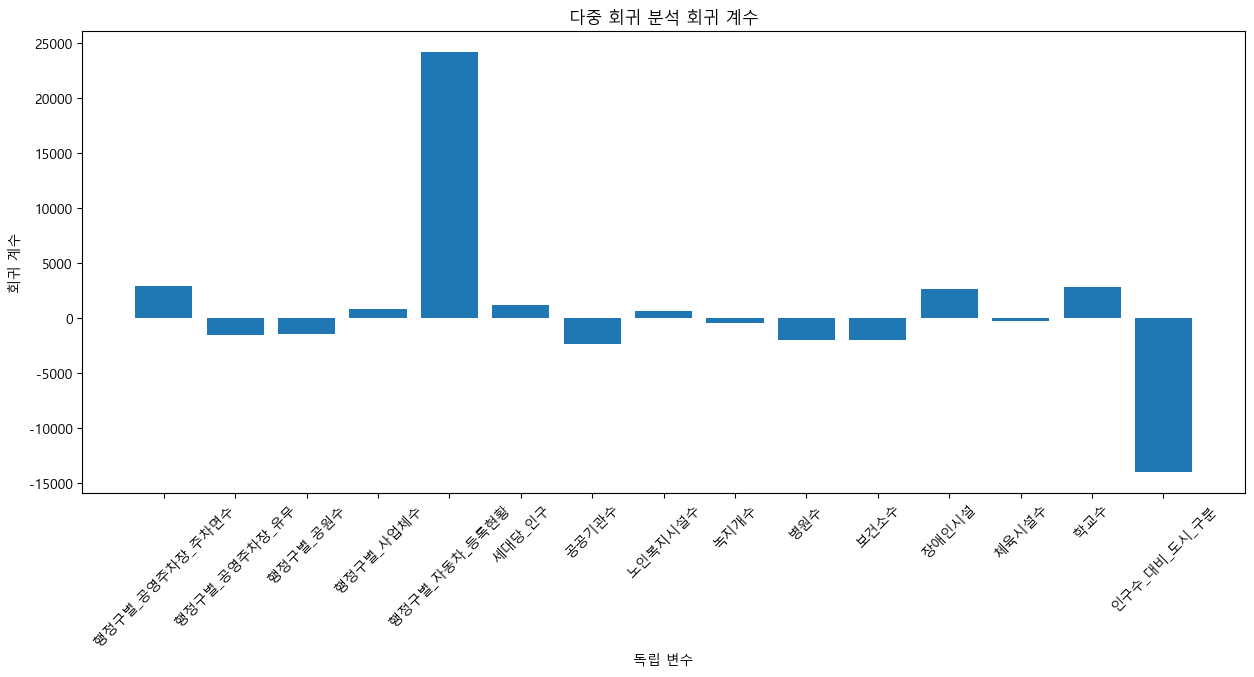

In [18]:
# 각 독립 변수의 이름과 회귀 계수를 연결하는 막대 그래프를 그립니다.
plt.figure(figsize=(15, 6))
plt.bar(X.columns, coefficients)
plt.xticks(rotation=45)  # x축 눈금을 45도 회전
plt.xlabel("독립 변수")
plt.ylabel("회귀 계수")
plt.title("다중 회귀 분석 회귀 계수")
plt.show()